### Keras model
Keras functionalities can be found under the tf.keras module. We have already used some of these functionalities to define layers and optimizers. In this unit, we will take it a step further to make full use of the tf.keras module. We will mainly work with the objects from its layers submodule and assemble them in a Sequential model.

In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [2]:
model = Sequential()
model.add(Dense(16, activation="relu", input_dim=28 * 28))
model.add(Dense(10, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


In this code, we first create the Sequential model and add each layer object. In our case, we create Dense layers by specifying the number of units, the activation function and the input dimensions i.e. a flat vector with 28*28=784 values. Note, the input only needs to be specified in the very first layer. Finally, we print a summary of our network that displays the different layers and their number of parameters. As we can see, most of them are in the hidden layer with 12,560 parameters i.e. 784*16=12,544 weights and 16 bias values.

When we use TensorFlow’s low-level interface, we set the last layer activation to None and then use the softmax_cross_entropy_with_logits loss function which computes the class probability distribution (softmax) and the loss value (cross-entropy) in one operation to avoid potential numerical issues. You can read more about this in this article. Keras handles this internally, and we don’t have to combine them into one operation: we can set the output layer activation to softmax and then use the cross-entropy loss function when defining the optimizer. One important difference is that our network will output the class probability distribution directly instead of the class scores (logits).

By default, Keras initializes the weights with the variance scaling technique that we have seen in the last subject. However, we can also manually specify the initializers

In [3]:
from tensorflow.keras import activations
from tensorflow.keras import initializers

# Create model
model = Sequential()

# Hidden layer
model.add(Dense(units=16, activation=activations.relu, input_dim=28 * 28,
                kernel_initializer=initializers.VarianceScaling(scale=2.0, seed=0)))

# Output layer
model.add(Dense(units=10, activation=activations.softmax,
                kernel_initializer=initializers.VarianceScaling(scale=1.0, seed=0)))

# Print network summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


This network is equivalent to the one from above but fixes the seed number to get reproducible results.

As you can see, Keras automatically adds the network variables and connects the operations according to our Sequential model definition.

#### Loss function and training operation

Let’s now see how to define the training elements with the Keras syntax:

In [4]:
from tensorflow.keras import optimizers

# Define loss function, optimizer and metrics to track during training
model.compile(optimizer="sgd",
              loss="sparse_categorical_crossentropy",
              metrics=["acc"])

Keras models provide a compile() function where we can specify the optimizer, the loss function and the metrics to monitor.

In the code from above, we used predefined tokens such as sgd or acc which are good defaults values. Again, we can also have more control over the different parameters by manually defining the objects from the Keras modules:

In [5]:
from tensorflow.keras import losses
from tensorflow.keras import metrics

# Define loss function, optimizer, and metrics to track during training
model.compile(
    optimizer="sgd",                         # .. or optimizers.SGD(lr=0.01)
    loss="sparse_categorical_crossentropy",  # .. or losses.sparse_categorical_crossentropy
    metrics=["acc"],                         # .. or metrics.sparse_categorical_accuracy
)

This code is equivalent to the one from above, but we can now specify the learning rate and the other parameters of the optimizer.

### Load/split data
Before training our MNIST classifier, let’s load and split the data. Keras already provides many datasets from its datasets module

In [6]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

11501568/11490434 [==============================] - 1s 0us/step
Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


In this code, we use the load_data() function from its mnist module which returns 60k-10k train/test splits with the 28x28 grayscale images and the 0-9 numerical labels.

Our dense network works with flat input vectors. So let’s reshape and standardize the data

In [7]:
from sklearn.preprocessing import StandardScaler

# Rescale train and validation data
scaler = StandardScaler()
X_train_preprocessed = scaler.fit_transform(X_train.reshape([-1, 784]).astype(float))
X_test_preprocessed = scaler.transform(X_test.reshape([-1, 784]).astype(float))

print("Train:", X_train_preprocessed.shape)
print("Test:", X_test_preprocessed.shape)

Train: (60000, 784)
Test: (10000, 784)


StandardScaler() is a great way to scale your data. However, such a scaler might potentially change the value distribution of your features. When working with RGB images which have values in a specific range (i.e. 0 to 255), a simple scaling by / 255. is already enough to bring your data between 0 and 1 (or /127.5 -1 to bring them between -1 and 1).

Replace the StandardScaler() above with a scaling by 255 and see how this changes your model performance?

### Training
In the previous units, we have manually implemented our own training loops. Keras encapsulates this process in its Model fit() function.

We pass the x/y training data, the batch_size, the number of epochs, the proportion of training data to keep with validation_split for monitoring the training process and the shuffling behavior which we set to True i.e. we shuffle the training data after each epoch.

You should see the training process, epoch after epoch:

In [8]:
# Fit model
history = model.fit(
    x=X_train_preprocessed,
    y=y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=25,
    shuffle=True,  # Shuffle training samples
)

Epoch 1/25
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6576 - acc: 0.8105 - val_loss: 0.3316 - val_acc: 0.9057
Epoch 2/25
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3144 - acc: 0.9094 - val_loss: 0.2712 - val_acc: 0.9210
Epoch 3/25
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2647 - acc: 0.9232 - val_loss: 0.2470 - val_acc: 0.9265
Epoch 4/25
1500/1500 [==============================] - 1s 801us/step - loss: 0.2385 - acc: 0.9294 - val_loss: 0.2313 - val_acc: 0.9316
Epoch 5/25
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2206 - acc: 0.9347 - val_loss: 0.2222 - val_acc: 0.9358
Epoch 6/25
1500/1500 [==============================] - 1s 739us/step - loss: 0.2072 - acc: 0.9387 - val_loss: 0.2152 - val_acc: 0.9378
Epoch 7/25
1500/1500 [==============================] - 1s 734us/step - loss: 0.1964 - acc: 0.9423 - val_loss: 0.2100 - val_acc: 0.9398
Epoch 8/25
1500/1500 [==============================] - 

Keras prints the training/validation loss and accuracy metrics that we specified in the metrics=['acc'] argument from the compile() step.

We can access those values via the history object returned by fit()

In [9]:
# The history object saved the scores during training
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Let’s plot the training curves using this object



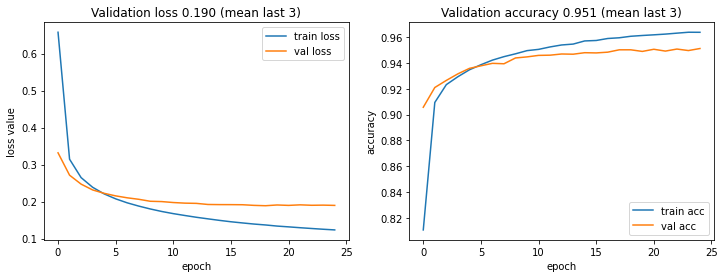

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Create two plots: one for the loss value, one for the accuracy
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot accuracy values
ax1.plot(history.history["loss"], label="train loss")
ax1.plot(history.history["val_loss"], label="val loss")
ax1.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(history.history["val_loss"][-3:])  # last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss value")
ax1.legend()

# Plot accuracy values
ax2.plot(history.history["acc"], label="train acc")
ax2.plot(history.history["val_acc"], label="val acc")
ax2.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(history.history["val_acc"][-3:])  # last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()
plt.show()

We can see that the validation loss and accuracy reach a plateau after 10 epochs. The model then starts overfitting.

### Evaluate test scores
Finally, let’s evaluate the test scores

In [11]:
(test_loss, test_accuracy) = model.evaluate(X_test_preprocessed, y_test, batch_size=32)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2f}%".format(100 * test_accuracy))

313/313 [==============================] - 0s 1ms/step - loss: 0.1902 - acc: 0.9487
Test loss: 0.19
Test accuracy: 94.87%


In this code, we use the Model evaluate() function to evaluate the metrics on a new dataset. Note that we can specify a batch size such that the evaluation is done by batches of data examples to reduce memory usage.

The function returns the metrics in the same order as the metrics_names model attribute



In [12]:
print(model.metrics_names)

['loss', 'acc']


### Visualize weights
We can extract the layers from our Sequential model with the layers attribute



In [13]:
model.layers

and then use those layers objects to inspect the model weights and biases with the get_weights() function. Let’s plot the weights with the code from the previous subject



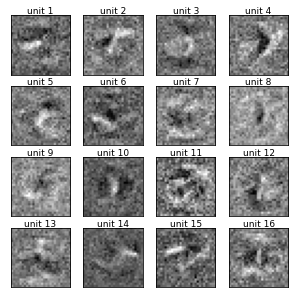

In [14]:
# Retrieve first hidden layer
hidden = model.layers[0]

# Get weights/biases
weights_hidden, biases_hidden = hidden.get_weights()

# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5, 5))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden[:, i]

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title("unit {}".format(i + 1), size=9, pad=2)
    axis.imshow(weights, cmap=plt.cm.gray_r)  # Grayscale
    axis.get_xaxis().set_visible(False)       # Disable x-axis
    axis.get_yaxis().set_visible(False)       # Disable y-axis

plt.show()


The weights look a bit noisy, adding regularization could potentially help

Try with dropout by adding tf.keras.layers.Dropout(x) layers to the Sequential model. Also try with regularization by setting the kernel_regularizer=tf.keras.regularizers.l2(x) parameters from Dense layers.